<a href="https://colab.research.google.com/github/ynsmrtpc/removebg.py/blob/main/removebg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision opencv-python pillow matplotlib
# U²-Net modelini yüklemek için gerekli olan repository
!git clone https://github.com/xuebinqin/U-2-Net.git
# U²-Net Ağırlıklarını Google Drive'dan indiriyoruz
!gdown --id 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O u2net.pth
# https://drive.usercontent.google.com/download?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&authuser=0

fatal: destination path 'U-2-Net' already exists and is not an empty directory.
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=e6d89ab6-d08d-4daa-a3ad-50324ebe5a59
To: /content/u2net.pth
100% 176M/176M [00:05<00:00, 33.8MB/s]


<ipython-input-24-b5d038613832>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("u2net.pth", map_location='cpu'))  # U²-Net ağırlıklarını 

Saving 16467754-1526663141.webp to 16467754-1526663141.webp


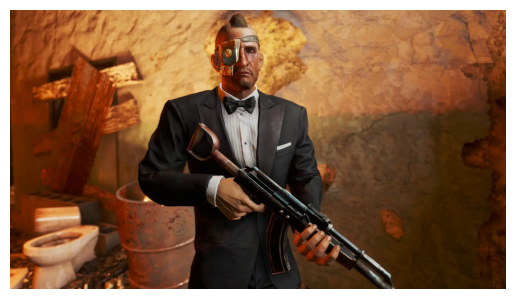

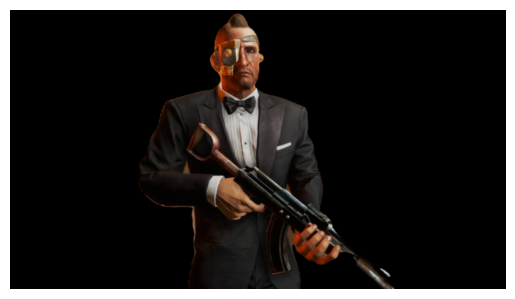

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import sys

sys.path.append('./U-2-Net')

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import files
from model import U2NET  # U²-Net modelini import ediyoruz

# Modeli yüklüyoruz
model = U2NET(3, 1)
model.load_state_dict(torch.load("u2net.pth", map_location='cpu'))  # U²-Net ağırlıklarını yükleme
model.eval()

# Resim yükleme işlemi
uploaded = files.upload()
input_image_path = next(iter(uploaded))
input_image = Image.open(input_image_path)

# Resmi gösteriyoruz
plt.imshow(input_image)
plt.axis('off')
plt.show()

# Resim üzerinde kontrast ve parlaklık artırma (Ön işleme)
image_np = np.array(input_image)
adjusted = cv2.convertScaleAbs(image_np, alpha=1.5, beta=30)  # Kontrast ve parlaklık
input_image = Image.fromarray(adjusted)

# Model için uygun forma dönüştürme
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((320, 320)),  # U²-Net için uygun boyut
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).unsqueeze(0)

# GPU kullanımı için model ve veriyi GPU'ya taşıyoruz
if torch.cuda.is_available():
    input_tensor = input_tensor.to('cuda')
    model.to('cuda')

# Segmentasyon işlemi (arka plan kaldırma)
with torch.no_grad():
    output = model(input_tensor)[0][:, 0, :, :]  # U²-Net çıkışı
    output = output.squeeze().cpu().numpy()  # Sonuç maskesi

# Maskeyi normalize etme ve threshold uygulama
output = cv2.resize(output, (image_np.shape[1], image_np.shape[0]))  # Maskeyi orijinal resim boyutuna getiriyoruz
output = (output - np.min(output)) / (np.max(output) - np.min(output))  # Normalize
output = np.where(output > 0.5, 1, 0).astype(np.uint8)  # Threshold ile maskeyi netleştirme

# Maskeyi uygulama (Son işleme)
r_channel = image_np[:, :, 0] * output
g_channel = image_np[:, :, 1] * output
b_channel = image_np[:, :, 2] * output
masked_image = np.stack([r_channel, g_channel, b_channel], axis=2)

# Gaussian Blur ile maskeyi yumuşatma (kenarları iyileştirme)
blurred_image = cv2.GaussianBlur(masked_image, (7, 7), 0)

# Sonucu görselleştirme
plt.imshow(blurred_image)
plt.axis('off')
plt.show()

# Sonucu kaydetme ve indirme
result_image = Image.fromarray(blurred_image.astype('uint8'))
result_image_path = 'arka_plani_kaldirilmis_resim.png'
result_image.save(result_image_path)
files.download(result_image_path)
